Use this notebook to run 1 denoiser step and get updated intermediate steps

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs-sdxl-depth').to(device)

In [5]:
assert cnxs.control_model.down_blocks[1].attentions[0].transformer_blocks[0].attn1.heads==1
assert cnxs.control_model.down_blocks[2].attentions[0].transformer_blocks[0].attn1.heads==2

In [6]:
cnxs.base_model = sdxl_pipe.unet

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

In [8]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Run

In [ ]:
import torch
import numpy as np
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image


depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas")#.to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values#.to("cuda")
    with torch.no_grad():#, torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image


prompt = "A robot, 4k photo"
image = load_image(
    "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main"
    "/kandinsky/cat.png"
).resize((1024, 1024))
controlnet_conditioning_scale = 0.5  # recommended for good generalization
depth_image = get_depth_map(image)

In [15]:
import random
def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [16]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0] / 14.6146

In [17]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

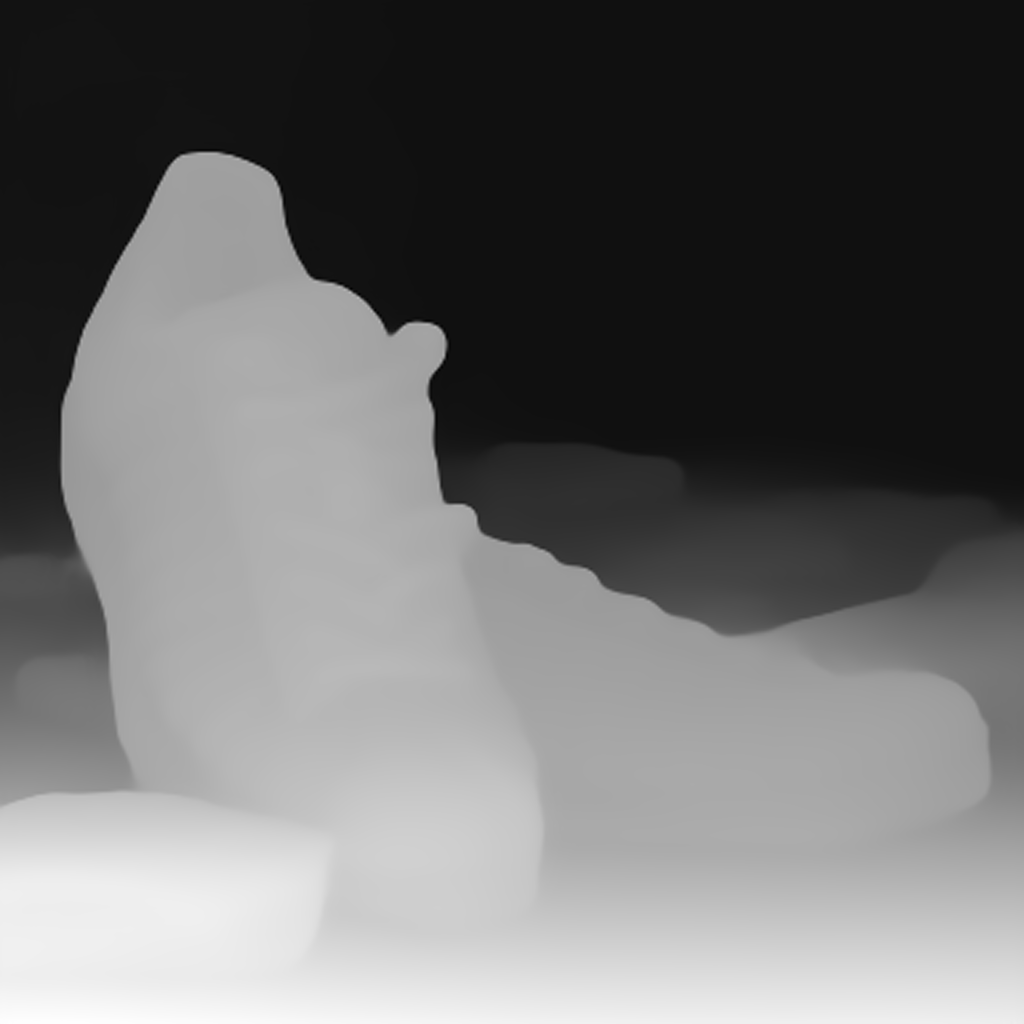

In [18]:
from PIL import Image 

image = load_image('input_images/shoe_cloud.png')
depth_image = depth_image = get_depth_map(image)
depth_image

In [19]:
from functools import partial
from util_plot import save_latents

In [20]:
seed_everything(RANDOM_SEED_IN_PAPER)
result = cnxs_pipe(prompt, negative_prompt=neg_prompt,image=depth_image, controlnet_conditioning_scale=.95)

  0%|          | 0/50 [00:00<?, ?it/s]

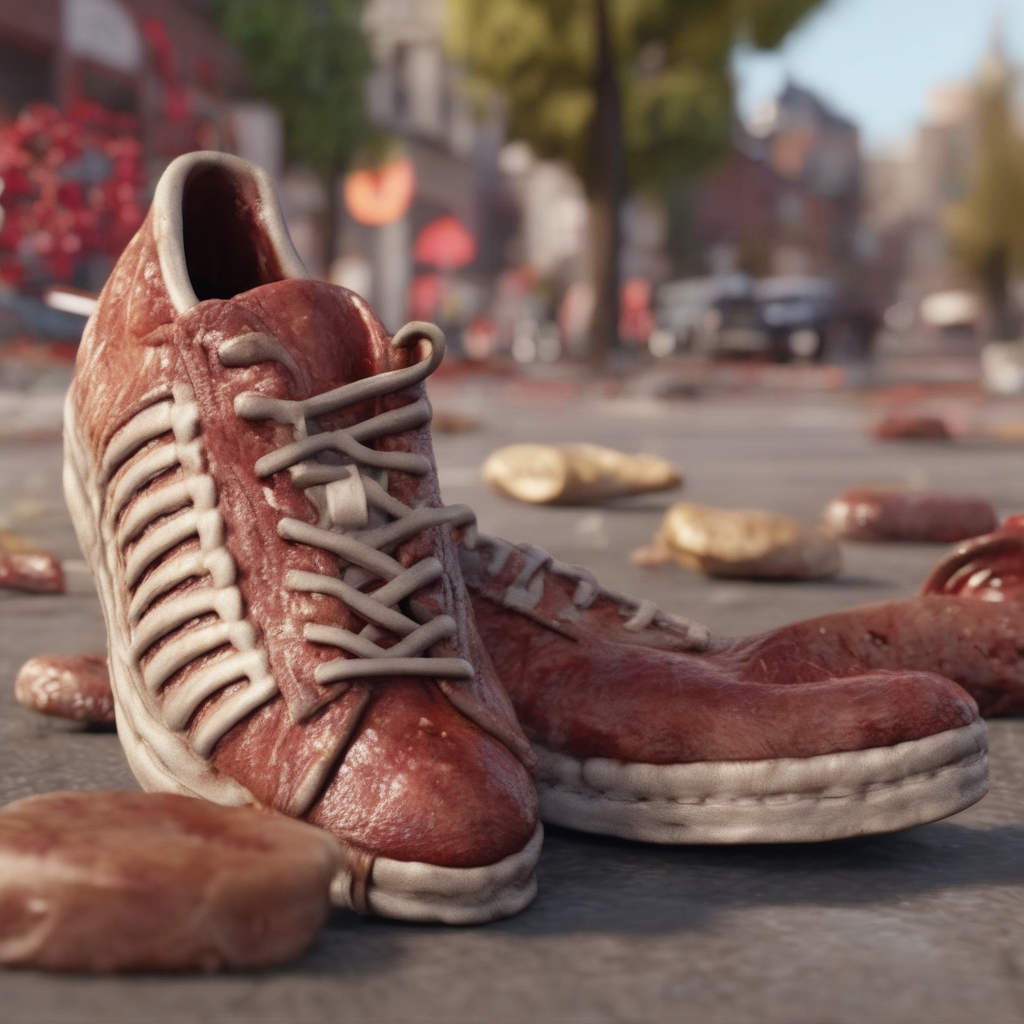

In [21]:
result.images[0]